In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os

In [3]:
PROJECT_DIR = os.path.abspath('.')
if PROJECT_DIR.endswith('final-nbs'):
    PROJECT_DIR = os.path.abspath('../')
    os.chdir(PROJECT_DIR)

In [4]:
import itertools
from src.data import join_dataframe_columns
from typing import List
from sklearn.preprocessing import scale, minmax_scale
from tqdm.auto import tqdm

def _compute_longest_consecutive_lenght(sequence: List[bool]) -> int:
    lenghts = [len(list(seq)) for value, seq in itertools.groupby(sequence)
                if value]
    return max(lenghts) if lenghts else 0

def longest_consecutive_above_mean(series: pd.Series) -> int:
    return _compute_longest_consecutive_lenght(series >= series.mean())


def min_max_ratio(series: pd.Series):
    return np.log1p(series.max() - series.min())

def compute_temperature_peak(df: pd.DataFrame):
    maximum_abun_index = np.argmax(df['abundance'].to_numpy())
    return df.iloc[maximum_abun_index]['temp']

def compute_features(data: pd.DataFrame) -> pd.DataFrame:
    data['abundance'] = np.power(data['abundance'], 1/8)
    data['rel_abun'] = data['abundance'] / data['abundance'].sum()
    agg_quantities_abun = (data.groupby(['m/z'])['rel_abun']
                       .agg(('sum', 'std', 'max', 'min', longest_consecutive_above_mean))
                       .fillna(0))

    temperature_peak_features = (data.groupby(['m/z'])
                             .apply(compute_temperature_peak)
                             .to_frame('temp_peak')
                             .fillna(0))
    agg_quantities_abun = pd.concat((agg_quantities_abun, temperature_peak_features), axis=1)
    
    return agg_quantities_abun



def compute_features_from_files(files, pd_metadata: pd.DataFrame):
    
    _mz_features = {}
    for sample_id in tqdm(files):
        sample_data = pd.read_csv(files[sample_id])
        sample_data = drop_mz_values(sample_data, remove_above_100=True)
        if pd_metadata.loc[sample_id, 'instrument_type'] == 'sam_testbed':
            sample_data = join_sambtest_sampling(sample_data)
        sample_mz_features = compute_features(sample_data)
        _mz_features[sample_id] = sample_mz_features 
    mz_features = (
        pd.concat(_mz_features,  names=['sample_id', 'm/z'])
    )
    model_mz_features = mz_features.reset_index().pivot('sample_id', 'm/z')
    join_dataframe_columns(model_mz_features)
    return model_mz_features.fillna(0)

In [5]:
import cfg
from src.data import get_features_path_from_metadata, join_dataframe_columns
from src import util
from src.data import setup_directories

util.setup_logging()

dirs = setup_directories(cfg.DATA_DIR, create_dirs=True)

In [6]:
raw_dir = Path(dirs['raw'])

In [7]:
# read metadata
pd_metadata = pd.read_csv(raw_dir / "metadata.csv", index_col="sample_id")
pd_metadata.head()

,split,instrument_type,features_path,features_md5_hash
sample_id,,,,
S0000,train,commercial,train_features/S0000.csv,017b9a71a702e81a828e6242aa15f049
S0001,train,commercial,train_features/S0001.csv,0d09840214054d254bd49436c6a6f315
S0002,train,commercial,train_features/S0002.csv,3f58b3c9b001bfed6ed4e4f757083e09
S0003,train,commercial,train_features/S0003.csv,e9a12f96114a2fda60b36f4c0f513fb1
S0004,train,commercial,train_features/S0004.csv,b67603d3931897bfa796ac42cc16de78


In [8]:
train_files = get_features_path_from_metadata(pd_metadata.query("split == 'train'"), raw_dir)
valid_files = get_features_path_from_metadata(pd_metadata.query("split == 'val'"), raw_dir)
test_files = get_features_path_from_metadata(pd_metadata.query("split != 'train'"), raw_dir)

In [9]:
len(train_files), len(valid_files), len(test_files)

(766, 293, 804)

In [10]:
from src.preprocessing import apply_preprocessing_fn

In [11]:
_train_mz_features = apply_preprocessing_fn(train_files, pd_metadata, processing_fn=compute_features)

train_mz_features = (
        pd.concat(_train_mz_features,  names=['sample_id', 'm/z'])
    )
train_mz_features = train_mz_features.reset_index().pivot('sample_id', 'm/z')
join_dataframe_columns(train_mz_features)
train_mz_features = train_mz_features.fillna(0)

  0%|          | 0/766 [00:00<?, ?it/s]

In [12]:
_valid_mz_features = apply_preprocessing_fn(valid_files, pd_metadata, processing_fn=compute_features)

valid_mz_features = (
        pd.concat(_valid_mz_features,  names=['sample_id', 'm/z'])
    )
valid_mz_features = valid_mz_features.reset_index().pivot('sample_id', 'm/z')
join_dataframe_columns(valid_mz_features)
valid_mz_features = valid_mz_features.fillna(0)

  0%|          | 0/293 [00:00<?, ?it/s]

In [13]:
_test_mz_features = apply_preprocessing_fn(test_files, pd_metadata, processing_fn=compute_features)

test_mz_features = (
        pd.concat(_test_mz_features,  names=['sample_id', 'm/z'])
    )
test_mz_features = test_mz_features.reset_index().pivot('sample_id', 'm/z')
join_dataframe_columns(test_mz_features)
test_mz_features = test_mz_features.fillna(0)

  0%|          | 0/804 [00:00<?, ?it/s]

In [14]:
train_mz_features.head()

,sum_mz0,sum_mz1,sum_mz2,sum_mz3,sum_mz5,sum_mz6,sum_mz7,sum_mz8,sum_mz9,sum_mz10,...,temp_peak_mz90,temp_peak_mz91,temp_peak_mz92,temp_peak_mz93,temp_peak_mz94,temp_peak_mz95,temp_peak_mz96,temp_peak_mz97,temp_peak_mz98,temp_peak_mz99
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,0.018374,0.018263,0.015952,0.017121,0.011513,0.009418,0.008905,0.008735,0.008364,0.008233,...,35.289,199.971,36.329,53.314,147.330,41.438,64.016,44.650,35.289,35.680
S0001,0.000000,0.026184,0.044014,0.033107,0.016639,0.013089,0.012260,0.011669,0.011043,0.010893,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
S0002,0.019023,0.020192,0.017197,0.018610,0.011999,0.009310,0.008872,0.009012,0.008478,0.008394,...,920.100,639.089,421.816,477.734,195.231,880.336,514.606,496.305,158.444,798.024
S0003,0.017703,0.018736,0.016254,0.017722,0.011581,0.009533,0.009090,0.009179,0.008676,0.008593,...,717.197,736.065,791.967,760.979,285.004,587.111,182.773,102.612,875.401,30.074
S0004,0.020583,0.021518,0.018754,0.019659,0.013848,0.009373,0.008670,0.008758,0.008244,0.008160,...,743.784,928.547,650.812,281.998,396.684,285.223,330.082,697.325,481.197,90.968


In [15]:
valid_mz_features.head()

,sum_mz0,sum_mz1,sum_mz2,sum_mz3,sum_mz5,sum_mz6,sum_mz7,sum_mz8,sum_mz9,sum_mz10,...,temp_peak_mz90,temp_peak_mz91,temp_peak_mz92,temp_peak_mz93,temp_peak_mz94,temp_peak_mz95,temp_peak_mz96,temp_peak_mz97,temp_peak_mz98,temp_peak_mz99
sample_id,,,,,,,,,,,,,,,,,,,,,
S0766,0.024916,0.026303,0.023475,0.024980,0.018560,0.011156,0.009426,0.009422,0.008863,0.008745,...,562.875,300.042,659.468,952.507,420.425,455.383,734.049,271.438,826.645,274.640
S0767,0.024215,0.025515,0.022663,0.024011,0.018015,0.010826,0.009118,0.009133,0.008605,0.008486,...,269.402,488.905,658.414,1044.488,109.845,234.255,695.980,492.055,42.543,31.475
S0768,0.021934,0.022989,0.020159,0.021353,0.014827,0.009875,0.009149,0.009377,0.008692,0.008564,...,677.304,130.510,906.805,593.223,866.603,931.444,461.104,156.000,995.929,857.370
S0769,0.016174,0.016406,0.014504,0.015783,0.010845,0.009115,0.008673,0.008492,0.008182,0.008043,...,235.934,573.993,723.243,94.395,521.538,552.337,122.100,860.290,118.313,484.161
S0770,0.020351,0.021246,0.018574,0.019557,0.013746,0.009320,0.008660,0.008805,0.008225,0.008136,...,463.503,126.622,222.565,489.413,624.004,747.521,126.622,71.223,756.763,759.856


In [16]:
test_mz_features.head()

,sum_mz0,sum_mz1,sum_mz2,sum_mz3,sum_mz5,sum_mz6,sum_mz7,sum_mz8,sum_mz9,sum_mz10,...,temp_peak_mz90,temp_peak_mz91,temp_peak_mz92,temp_peak_mz93,temp_peak_mz94,temp_peak_mz95,temp_peak_mz96,temp_peak_mz97,temp_peak_mz98,temp_peak_mz99
sample_id,,,,,,,,,,,,,,,,,,,,,
S0766,0.024916,0.026303,0.023475,0.024980,0.018560,0.011156,0.009426,0.009422,0.008863,0.008745,...,562.875,300.042,659.468,952.507,420.425,455.383,734.049,271.438,826.645,274.640
S0767,0.024215,0.025515,0.022663,0.024011,0.018015,0.010826,0.009118,0.009133,0.008605,0.008486,...,269.402,488.905,658.414,1044.488,109.845,234.255,695.980,492.055,42.543,31.475
S0768,0.021934,0.022989,0.020159,0.021353,0.014827,0.009875,0.009149,0.009377,0.008692,0.008564,...,677.304,130.510,906.805,593.223,866.603,931.444,461.104,156.000,995.929,857.370
S0769,0.016174,0.016406,0.014504,0.015783,0.010845,0.009115,0.008673,0.008492,0.008182,0.008043,...,235.934,573.993,723.243,94.395,521.538,552.337,122.100,860.290,118.313,484.161
S0770,0.020351,0.021246,0.018574,0.019557,0.013746,0.009320,0.008660,0.008805,0.008225,0.008136,...,463.503,126.622,222.565,489.413,624.004,747.521,126.622,71.223,756.763,759.856


In [17]:
assert train_mz_features.shape[1] == valid_mz_features.shape[1]
assert train_mz_features.shape[1] == test_mz_features.shape[1]

In [18]:
assert all(train_mz_features.columns == valid_mz_features.columns)
assert all(train_mz_features.columns == test_mz_features.columns)

#### can we predict wheter is sam_tested or not? 

In [19]:
joined_mz_data = train_mz_features.append(test_mz_features)

In [20]:
sam_testbed_samples = pd_metadata.index[(pd_metadata['instrument_type'] == 'sam_testbed')]

In [21]:
joined_mz_data['is_sam_testbed'] = joined_mz_data.index.isin(sam_testbed_samples).astype(np.int64)

In [22]:
joined_mz_data['is_sam_testbed'].sum()

76

In [23]:
feature_names = train_mz_features.columns

In [24]:
# we will use mutual information scores to determine if any feature could tell us something

In [25]:
from sklearn.feature_selection import mutual_info_classif

In [26]:
mi_scores = mutual_info_classif(joined_mz_data[feature_names], joined_mz_data['is_sam_testbed'])

In [27]:
mi_scores = pd.Series(mi_scores, index=feature_names, name='mi').sort_values(ascending=False)

In [28]:
mi_scores.head(10) # lets look at most important feature

min_mz40                              0.187534
min_mz14                              0.184924
sum_mz69                              0.183214
sum_mz21                              0.179694
min_mz35                              0.178035
max_mz14                              0.177412
longest_consecutive_above_mean_mz6    0.176167
min_mz31                              0.175954
sum_mz6                               0.175788
max_mz32                              0.175120
Name: mi, dtype: float64

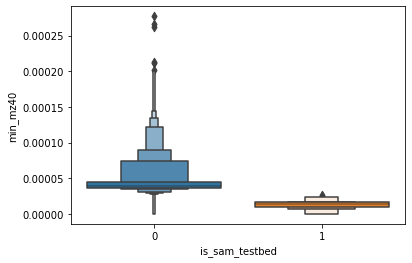

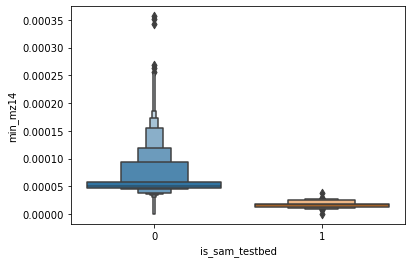

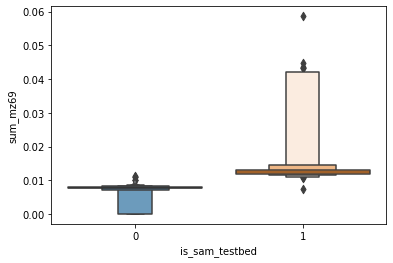

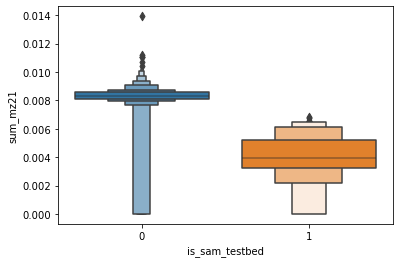

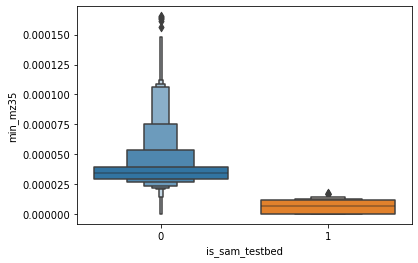

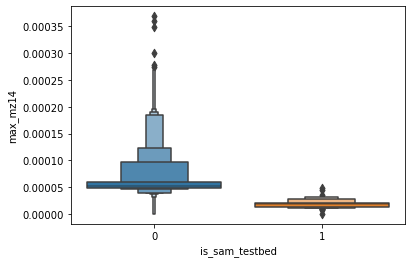

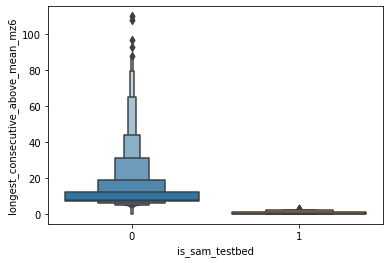

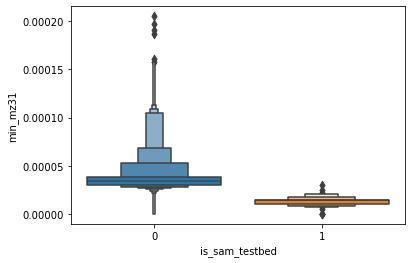

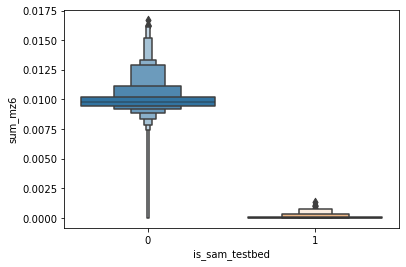

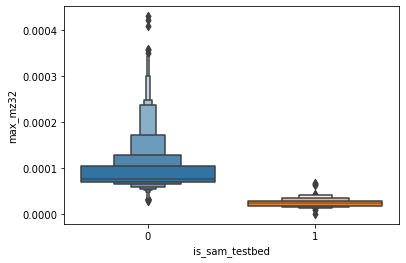

In [29]:
for top_feat in mi_scores.index[:10]:
    plt.figure()
    sns.boxenplot(data=joined_mz_data, x='is_sam_testbed', y=top_feat)

because they are few sam tesbed observations we can surely predict if we can tell difference between one and other, but at least they are in the same scale.

finally, normalize using quantile transformer to reduce variance in the dataset

### looking at correlations 

In [30]:
def get_upper_traingle(data: pd.DataFrame):
    shape = data.shape
    upper_tri = np.triu(np.ones(shape, dtype=np.bool_), k=1)
    return data.where(upper_tri)

In [31]:
corr_matrix = train_mz_features.corr()

In [32]:
utriu_corr = get_upper_traingle(corr_matrix)

In [33]:
high_correlated_features = [f for f in utriu_corr if utriu_corr[f].abs().max() >= 0.95]

In [34]:
len(high_correlated_features) # very correlated features, but what to drop???

243

In [35]:
high_correlated_features

['sum_mz5',
 'sum_mz8',
 'sum_mz9',
 'sum_mz10',
 'sum_mz11',
 'sum_mz40',
 'sum_mz45',
 'sum_mz46',
 'sum_mz52',
 'sum_mz53',
 'sum_mz55',
 'sum_mz56',
 'sum_mz58',
 'sum_mz59',
 'sum_mz66',
 'sum_mz68',
 'sum_mz69',
 'sum_mz70',
 'sum_mz71',
 'sum_mz72',
 'sum_mz73',
 'sum_mz74',
 'sum_mz75',
 'sum_mz76',
 'sum_mz77',
 'sum_mz78',
 'sum_mz79',
 'sum_mz80',
 'sum_mz81',
 'sum_mz82',
 'sum_mz83',
 'sum_mz84',
 'sum_mz85',
 'sum_mz86',
 'sum_mz87',
 'sum_mz88',
 'sum_mz89',
 'sum_mz90',
 'sum_mz91',
 'sum_mz92',
 'sum_mz93',
 'sum_mz94',
 'sum_mz95',
 'sum_mz96',
 'sum_mz97',
 'sum_mz98',
 'sum_mz99',
 'std_mz8',
 'std_mz9',
 'std_mz10',
 'std_mz18',
 'std_mz20',
 'std_mz36',
 'std_mz37',
 'std_mz38',
 'std_mz41',
 'std_mz44',
 'std_mz45',
 'std_mz46',
 'std_mz50',
 'std_mz53',
 'std_mz54',
 'std_mz55',
 'std_mz56',
 'std_mz57',
 'std_mz65',
 'std_mz66',
 'std_mz72',
 'std_mz75',
 'std_mz78',
 'std_mz79',
 'std_mz80',
 'std_mz81',
 'std_mz82',
 'std_mz84',
 'std_mz87',
 'std_mz88',
 'st

In [36]:
from sklearn.preprocessing import QuantileTransformer
from src.data import build_dataframe_as
quantile_transformer = QuantileTransformer(n_quantiles=50)

In [37]:
_train_mz_norm_features = quantile_transformer.fit_transform(train_mz_features)

In [38]:
_valid_mz_norm_features = quantile_transformer.transform(valid_mz_features)

In [39]:
_test_mz_norm_features = quantile_transformer.transform(test_mz_features)

In [40]:
train_mz_norm_features = build_dataframe_as(_train_mz_norm_features, train_mz_features)

In [41]:
valid_mz_norm_features = build_dataframe_as(_valid_mz_norm_features, valid_mz_features)

In [42]:
test_mz_norm_features = build_dataframe_as(_test_mz_norm_features, test_mz_features)

In [43]:
train_mz_norm_features.head()

,sum_mz0,sum_mz1,sum_mz2,sum_mz3,sum_mz5,sum_mz6,sum_mz7,sum_mz8,sum_mz9,sum_mz10,...,temp_peak_mz90,temp_peak_mz91,temp_peak_mz92,temp_peak_mz93,temp_peak_mz94,temp_peak_mz95,temp_peak_mz96,temp_peak_mz97,temp_peak_mz98,temp_peak_mz99
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,0.340020,0.199854,0.166877,0.200833,0.199872,0.238830,0.438316,0.211829,0.388056,0.333829,...,0.089245,0.229957,0.081612,0.124142,0.203451,0.103749,0.139557,0.104356,0.081609,0.089870
S0001,0.000000,0.913373,0.977375,0.979591,0.816223,0.956738,0.990920,0.978159,0.984134,0.983821,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
S0002,0.410304,0.380667,0.326579,0.354215,0.328515,0.186832,0.408898,0.403704,0.505228,0.512138,...,0.927101,0.769674,0.494778,0.535845,0.238448,0.892560,0.634800,0.596683,0.238674,0.839972
S0003,0.244877,0.219661,0.181182,0.234663,0.219038,0.299011,0.648236,0.552235,0.677699,0.692326,...,0.763939,0.835352,0.857590,0.816360,0.334546,0.699620,0.231548,0.182711,0.918799,0.079698
S0004,0.501639,0.469028,0.420880,0.452981,0.476947,0.224536,0.251611,0.229189,0.279814,0.265029,...,0.783448,0.937656,0.763923,0.347323,0.456205,0.363140,0.413243,0.762212,0.614587,0.164420


In [44]:
valid_mz_norm_features.head()

,sum_mz0,sum_mz1,sum_mz2,sum_mz3,sum_mz5,sum_mz6,sum_mz7,sum_mz8,sum_mz9,sum_mz10,...,temp_peak_mz90,temp_peak_mz91,temp_peak_mz92,temp_peak_mz93,temp_peak_mz94,temp_peak_mz95,temp_peak_mz96,temp_peak_mz97,temp_peak_mz98,temp_peak_mz99
sample_id,,,,,,,,,,,,,,,,,,,,,
S0766,0.926832,0.920168,0.871866,0.897009,0.924933,0.885182,0.889630,0.759408,0.830921,0.822919,...,0.628485,0.353115,0.771318,0.955898,0.488676,0.563696,0.793204,0.362277,0.892721,0.371154
S0767,0.875786,0.857193,0.809102,0.840202,0.874561,0.831915,0.680906,0.508129,0.610400,0.587853,...,0.356538,0.619688,0.770417,0.982399,0.166325,0.305998,0.754846,0.591354,0.102325,0.080559
S0768,0.614612,0.576422,0.549181,0.580665,0.569098,0.555131,0.708918,0.730219,0.699708,0.659404,...,0.736328,0.143316,0.924046,0.659486,0.884665,0.932888,0.576274,0.237483,0.980445,0.886740
S0769,0.145793,0.101693,0.068192,0.111700,0.105252,0.122069,0.253158,0.114170,0.238842,0.180948,...,0.313389,0.722597,0.815900,0.171447,0.606924,0.661438,0.194324,0.898284,0.206473,0.583219
S0770,0.482291,0.446705,0.411472,0.443042,0.465338,0.192720,0.245275,0.254300,0.263622,0.248114,...,0.535473,0.139230,0.283708,0.550799,0.697463,0.789558,0.196901,0.139135,0.844509,0.806671


In [45]:
test_mz_norm_features.head()

,sum_mz0,sum_mz1,sum_mz2,sum_mz3,sum_mz5,sum_mz6,sum_mz7,sum_mz8,sum_mz9,sum_mz10,...,temp_peak_mz90,temp_peak_mz91,temp_peak_mz92,temp_peak_mz93,temp_peak_mz94,temp_peak_mz95,temp_peak_mz96,temp_peak_mz97,temp_peak_mz98,temp_peak_mz99
sample_id,,,,,,,,,,,,,,,,,,,,,
S0766,0.926832,0.920168,0.871866,0.897009,0.924933,0.885182,0.889630,0.759408,0.830921,0.822919,...,0.628485,0.353115,0.771318,0.955898,0.488676,0.563696,0.793204,0.362277,0.892721,0.371154
S0767,0.875786,0.857193,0.809102,0.840202,0.874561,0.831915,0.680906,0.508129,0.610400,0.587853,...,0.356538,0.619688,0.770417,0.982399,0.166325,0.305998,0.754846,0.591354,0.102325,0.080559
S0768,0.614612,0.576422,0.549181,0.580665,0.569098,0.555131,0.708918,0.730219,0.699708,0.659404,...,0.736328,0.143316,0.924046,0.659486,0.884665,0.932888,0.576274,0.237483,0.980445,0.886740
S0769,0.145793,0.101693,0.068192,0.111700,0.105252,0.122069,0.253158,0.114170,0.238842,0.180948,...,0.313389,0.722597,0.815900,0.171447,0.606924,0.661438,0.194324,0.898284,0.206473,0.583219
S0770,0.482291,0.446705,0.411472,0.443042,0.465338,0.192720,0.245275,0.254300,0.263622,0.248114,...,0.535473,0.139230,0.283708,0.550799,0.697463,0.789558,0.196901,0.139135,0.844509,0.806671


In [46]:
### saving

In [47]:
train_dir = Path(dirs['train'])
valid_dir = Path(dirs['valid'])
test_dir = Path(dirs['test'])

In [48]:
train_mz_norm_features.to_csv(train_dir / 'mz_agg_features.csv', index=True)
(
    train_mz_norm_features
    .drop(high_correlated_features, axis=1)
    .to_csv(train_dir / 'mz_agg_features_drop_correlated.csv', index=True)
)

In [49]:
valid_mz_norm_features.to_csv(valid_dir / 'mz_agg_features.csv', index=True)
(
    valid_mz_norm_features
    .drop(high_correlated_features, axis=1)
    .to_csv(valid_dir / 'mz_agg_features_drop_correlated.csv', index=True)
)

In [50]:
test_mz_norm_features.to_csv(test_dir / 'mz_agg_features.csv', index=True)
(
    test_mz_norm_features
    .drop(high_correlated_features, axis=1)
    .to_csv(test_dir / 'mz_agg_features_drop_correlated.csv', index=True)
)